In [4]:
# Load Python packages required for the analysis
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
# Main functiopn that interacts with SHAP
# In this use case we are using output generated from a legacy model 
# SHAP call
def shap_generic_model(model_df, predValName, numsim):

    X_all = model_df.drop([predValName], axis=1)
    X_all = X_all.sample(n=(5*numsim), random_state=1)
    X_train, X_test = train_test_split(X_all, test_size=0.2, shuffle=True)

    headers = X_all.columns.tolist()

    ######### 
    ## Simple look up into known set of model outputs
    ##
    #########
    def predict_helper(x):
        query_string = ""
        for i in range(len(x)):
            if i == 0:
                cond = headers[i] + " == " + str(x[i])

            else:
                cond = " and " + headers[i] + " == " + str(x[i])

            query_string += cond

        record = model_df.query(query_string)

        return record[predValName]

    def predict(Xs):
        Ys = np.empty(Xs.shape[0])
        for row in range(Xs.shape[0]):
            prediction = predict_helper(Xs[row])
            np.put(Ys, row, prediction)

        return Ys

    model = shap.common.Model(predict, predValName)
    ##########################################
    # SHAP provides a series of explainers
    # KernelExplainer can support "any" model
    # The KernelExplainer builds a weighted linear regression by using your data, your predictions, 
    # and whatever function that predicts the predicted values. 
    # It computes the variable importance values based on the Shapley values from game theory, 
    # and the coefficients from a local linear regression
    #####################################################
    explainer = shap.KernelExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False,l1_reg="num_features(10)")
    expected_value = explainer.expected_value

    return shap_values, expected_value, X_test


In [6]:
model_path = "RollRates.csv"
df = pd.read_csv(model_path, encoding='utf-8')
predict_val = "RollRate"
numsim = 10
df.head()

,HPI,Rates,UE,FICO,Age,RollRate
0,-50,-3.0,0.0,650,12,0.670550
1,-45,-3.0,0.0,650,12,0.485970
2,-40,-3.0,0.0,650,12,0.370584
3,-35,-3.0,0.0,650,12,0.292557
4,-30,-3.0,0.0,650,12,0.236592


In [8]:
shap_values, expected_value, stest = shap_generic_model(df, predict_val, numsim)

HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=10.0), HTML(value='')))

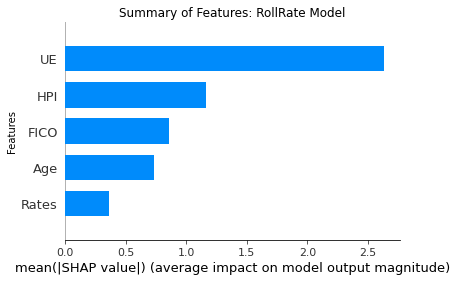

In [9]:
plt.title(label="Summary of Features: " + predict_val + " Model")
plt.ylabel(ylabel="Features")
plt.xlabel(xlabel="Model Impact")
shap.summary_plot(shap_values, stest,show=True, plot_size=None,plot_type="bar")


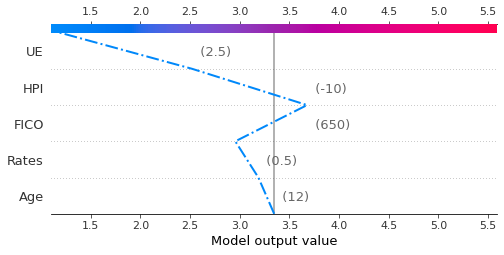

In [19]:
# Path Plot                                                                                                                                                                
sample_index = numsim-1
plt.xlabel(xlabel="Model Output Value")
shap.decision_plot(expected_value, shap_values[sample_index], stest, feature_names=stest.columns.tolist(), show=True, highlight=0)


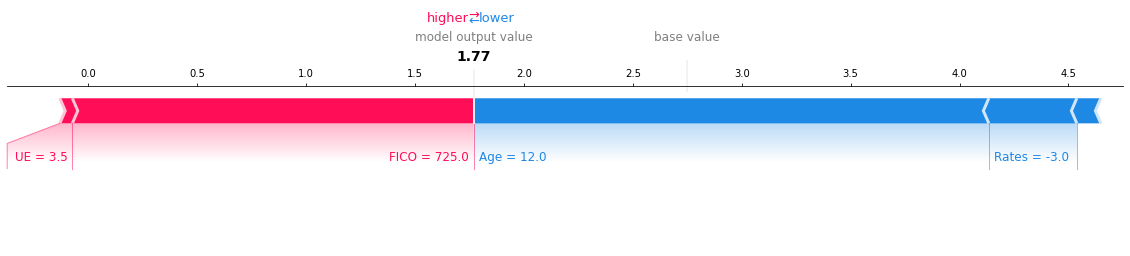

In [10]:
# Force Plot                                                                                                                                                               
sample_index = 3
shap.force_plot(expected_value, shap_values[sample_index], stest.iloc[sample_index], feature_names=stest.columns.tolist(),matplotlib=True, show=True)
